Import

In [ ]:
import time
seed = int(time.time())

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

2.14.0


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
os.chdir('/gdrive/My Drive/Colab Notebooks')

Mounted at /gdrive


Data Treatment

In [ ]:
leafs_data = np.load("new_public_data.npz", allow_pickle=True)
data_leafs = np.array(leafs_data["array1"]).astype(int)
labels = np.array(leafs_data['array2'])

print((pd.DataFrame(labels)).value_counts())
labels = pd.DataFrame(labels)
labels.describe()
# Turning the classes into a binary coding 00:Unhealthy, 01:Healthy
unique = labels.iloc[: , 0].unique()

loc = [1,2]
for pos in zip(loc , unique):
    labels.insert(pos[0] , pos[1] , pos[0] - 1)

labels_1 = labels
labels_1.loc[labels[0] == 'healthy' , 'healthy'] = 1
labels_1.loc[labels[0] == 'healthy', 'unhealthy'] = 0
labels = labels_1
labels = labels.drop(columns = 0)

healthy      3101
unhealthy    1903
dtype: int64


labels_leafs = np.expand_dims(labels_leafs, axis=-1)
values_leafs = np.array([])
num = 0
for i in labels_leafs:
  if i == "healthy":
    values_leafs = np.append(values_leafs, [0])
  else:
    values_leafs = np.append(values_leafs, [1])
values_leafs = np.expand_dims(values_leafs, axis=-1)

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data_leafs,
    labels,
    test_size = 0.1,
    random_state=seed,
    stratify= labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test), # Ensure validation set size matches test set size
    random_state=seed,
    stratify= y_train_val
)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]
batch_size = 64
epochs = 300

In [ ]:
def build_V2M(input_shape, output_shape, dropout_rate, seed=seed):
    tf.random.set_seed(seed)

    augmentation = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal", seed=seed),
        tfkl.RandomFlip("vertical", seed=seed),
        tfkl.RandomBrightness(0.3, value_range=(0,255), seed=seed),
        tfkl.RandomContrast(0.3, seed=seed),
        tfkl.RandomZoom((0.2, 0.2), seed=seed),
        tfkl.RandomTranslation(0.2, 0.2, seed=seed)
    ], name='augmentation')

    V2M = tfk.applications.EfficientNetV2M(
        input_shape = input_shape,
        include_top=False,
        weights="imagenet",
        pooling='avg',
    )
    V2M.trainable = False

    input_layer = tfk.Input(shape=input_shape)

    x = augmentation(input_layer)
    x = V2M(x, training=False)

    dropout = tfkl.Dropout(
        dropout_rate,
        seed=seed
    )(x)

    classifier_layer = tfkl.Dense(
        units=16,
        activation='relu',
        name='dense1'
    )(dropout)

    dropout = tfkl.Dropout(
        dropout_rate,
        seed=seed
    )(classifier_layer)

    BCL = tfkl.BatchNormalization(

    )(dropout)

    output_layer = tfkl.Dense(
        units=output_shape,
        activation='sigmoid',
        name='dense2'
    )(BCL)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='V2B3')

    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    return model

tl_model = build_V2M(input_shape, output_shape, 0.5)
tl_model.summary()

214201816/214201816 [==============================] - 6s 0us/step
Model: "V2B3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 augmentation (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-m (Function  (None, 1280)              53150388  
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense1 (Dense)              (None, 16)                20496     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0     

In [ ]:
patience=20
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, mode='max', restore_best_weights=True)
lr_patience = 10
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',# Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,   # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.1,            # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-5            # Minimum learning rate
)

In [ ]:
history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
).history

Epoch 1/300
63/63 [==============================] - 38s 162ms/step - loss: 0.7742 - accuracy: 0.5577 - val_loss: 0.6365 - val_accuracy: 0.6387 - lr: 0.0010
Epoch 2/300
63/63 [==============================] - 5s 74ms/step - loss: 0.6816 - accuracy: 0.6394 - val_loss: 0.6143 - val_accuracy: 0.7106 - lr: 0.0010
Epoch 3/300
63/63 [==============================] - 4s 68ms/step - loss: 0.6349 - accuracy: 0.6667 - val_loss: 0.6078 - val_accuracy: 0.6826 - lr: 0.0010
Epoch 4/300
63/63 [==============================] - 5s 73ms/step - loss: 0.6023 - accuracy: 0.6867 - val_loss: 0.5703 - val_accuracy: 0.7405 - lr: 0.0010
Epoch 5/300
63/63 [==============================] - 4s 67ms/step - loss: 0.5948 - accuracy: 0.6899 - val_loss: 0.5540 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 6/300
63/63 [==============================] - 5s 72ms/step - loss: 0.5931 - accuracy: 0.6924 - val_loss: 0.5464 - val_accuracy: 0.7505 - lr: 0.0010
Epoch 7/300
63/63 [==============================] - 4s 68ms/step - 

Predictions Shape: (501, 2)
Accuracy: 0.7565
Precision: 0.7465
Recall: 0.7248
F1: 0.7314


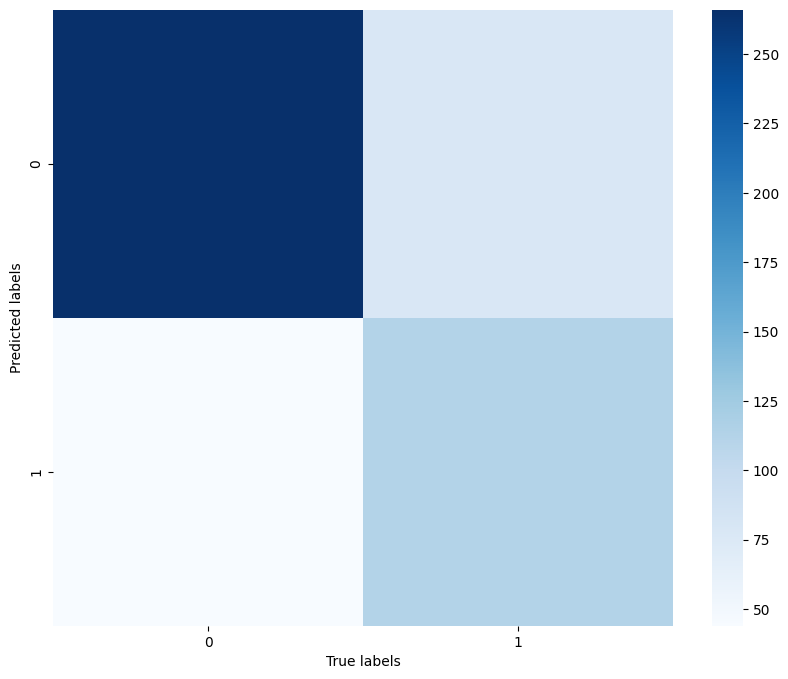

In [ ]:
predictions = tl_model.predict(X_test, verbose=0)
print("Predictions Shape:", predictions.shape)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1))
precision = precision_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')
recall = recall_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')
f1 = f1_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels={0, 1}, yticklabels={0, 1}, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Fine tuning

In [ ]:
tl_model.get_layer('efficientnetv2-m').trainable = True

In [ ]:
N = 340
#for i, layer in enumerate(tl_model.get_layer('efficientnetv2-b3').layers[:N]):
#  layer.trainable=False
tl_model.summary()
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-6), metrics=['accuracy'])

Model: "V2B3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 augmentation (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-m (Function  (None, 1280)              53150388  
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense1 (Dense)              (None, 16)                20496     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                              

In [ ]:
history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
).history

Epoch 1/300
63/63 [==============================] - 120s 278ms/step - loss: 0.5444 - accuracy: 0.7291 - val_loss: 0.4982 - val_accuracy: 0.7964 - lr: 1.0000e-06
Epoch 2/300
63/63 [==============================] - 12s 194ms/step - loss: 0.5286 - accuracy: 0.7369 - val_loss: 0.4901 - val_accuracy: 0.8044 - lr: 1.0000e-06
Epoch 3/300
63/63 [==============================] - 12s 194ms/step - loss: 0.5301 - accuracy: 0.7414 - val_loss: 0.4798 - val_accuracy: 0.8064 - lr: 1.0000e-06
Epoch 4/300
63/63 [==============================] - 12s 194ms/step - loss: 0.5332 - accuracy: 0.7334 - val_loss: 0.4706 - val_accuracy: 0.8144 - lr: 1.0000e-06
Epoch 5/300
63/63 [==============================] - 12s 189ms/step - loss: 0.5091 - accuracy: 0.7471 - val_loss: 0.4666 - val_accuracy: 0.7924 - lr: 1.0000e-06
Epoch 6/300
63/63 [==============================] - 12s 194ms/step - loss: 0.5020 - accuracy: 0.7536 - val_loss: 0.4650 - val_accuracy: 0.8164 - lr: 1.0000e-06
Epoch 7/300
63/63 [==============

Predictions Shape: (501, 2)
Accuracy: 0.9002
Precision: 0.9057
Recall: 0.8822
F1: 0.8913


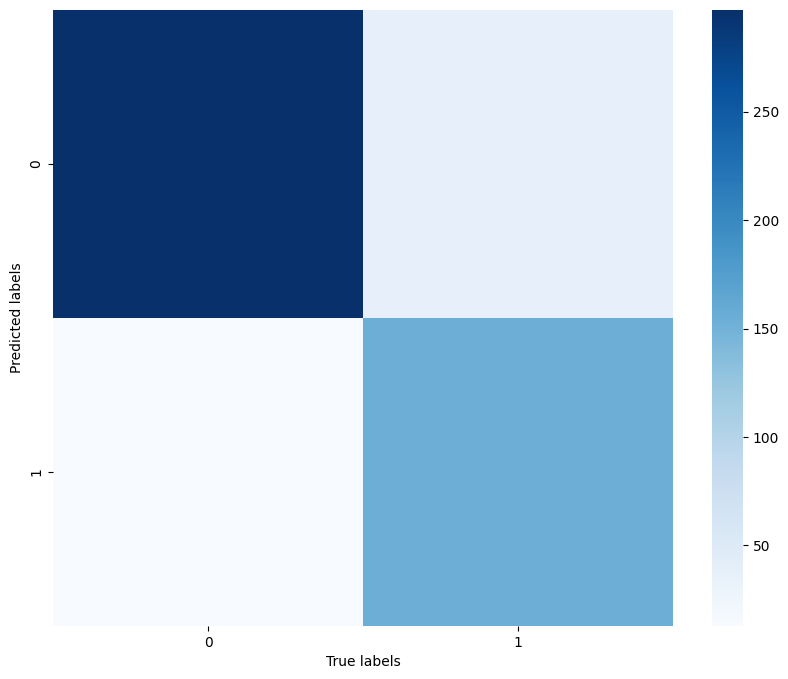

In [ ]:
predictions = tl_model.predict(X_test, verbose=0)
print("Predictions Shape:", predictions.shape)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1))
precision = precision_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')
recall = recall_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')
f1 = f1_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels={0, 1}, yticklabels={0, 1}, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
tl_model.save('V2M_1.h5')